In [8]:
# import the necessary packages
from datetime import datetime
from datetime import timedelta
import mplfinance as mpf
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np

## Doji Detection Example - NVDA (Daily)

In [2]:
# define the start and end dates for the history request
end_date = datetime(year=2024, month=9, day=1)
start_date = end_date - timedelta(days=90)

In [44]:
# define the ticker we are interested in
ticker = "XOM"

# fetch daily OHLVC bars for the ticker
df = yf.download(
    tickers=ticker,
    start=start_date,
    end=end_date,
    interval="1d",
    progress=False
)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-03,116.300003,116.360001,113.760002,114.449997,113.535934,19589300
2024-06-04,113.000000,113.089996,110.919998,112.669998,111.770157,19412200
2024-06-05,112.889999,113.190002,111.480003,113.120003,112.216568,14863500
2024-06-06,112.750000,114.040001,112.110001,113.970001,113.059776,13154100
2024-06-07,113.790001,114.900002,112.669998,112.750000,111.849518,13289200
...,...,...,...,...,...,...
2024-08-26,117.760002,118.940002,116.919998,118.809998,118.809998,13671000
2024-08-27,118.959999,119.410004,117.400002,117.680000,117.680000,9991600
2024-08-28,117.000000,117.580002,116.260002,116.519997,116.519997,10742900


In [45]:
# detect all Inside candles in the dataframe, where '0' is no inside candle
# detected, '1' is an inside candle with close > open, and '-1' for an inside
# candle with close < open
df["Inside"] = df.ta.cdl_pattern(name="inside")
df[df["Inside"] != 0]

,Open,High,Low,Close,Adj Close,Volume,Inside
Date,,,,,,,
2024-06-10,113.059998,114.220001,112.699997,113.080002,112.176880,15245200,1
2024-07-03,114.269997,115.660004,114.269997,114.760002,113.843468,7732900,1
2024-08-06,114.449997,115.629997,113.629997,114.160004,113.248260,13647800,-1
2024-08-15,118.250000,119.629997,118.120003,118.730003,118.730003,11579400,1


In [46]:
# create a series for both bullish and bearish inside candle detections
bullish_inside = df["Inside"] == 1
bearish_inside = df["Inside"] == -1

# create a dataframe to store the horizontal lines we'll plot for the bullish
# and bearish inside candle detections
bullish_lines = pd.DataFrame(index=df.index)
bearish_lines = pd.DataFrame(index=df.index)

# compute the positions of the bullish lines such that a horizontal line will
# be drawn *above* the two inside candles
bullish_lines["Lines"] = np.where(
    bullish_inside,
    df["High"] * 1.01,
    np.nan
)

# compute positions for the bearish lines, this time placing the horizontal
# line *below* the two inside candles
bearish_lines["Lines"] = np.where(
    bearish_inside,
    df["Low"].shift(1) * 0.99,
    np.nan
)

# since inside patterns consist of two candles, we need to forward fill a
# maximum of one value in our lines
bullish_lines["Lines"] = bullish_lines["Lines"].ffill(limit=1)
bearish_lines["Lines"] = bearish_lines["Lines"].ffill(limit=1)

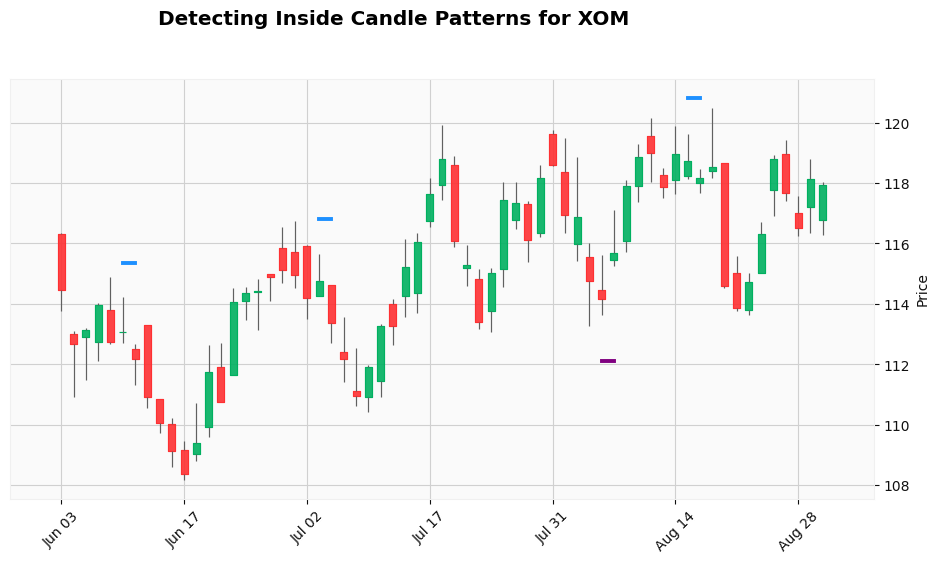

In [47]:
# initialize a list of additional plots
addt_plots = []

# ensure at least one bullish Inside candle was detected
if not bullish_lines["Lines"].isna().all():
    # update the plots with the bullish Inside candle markers
    addt_plots.append(
        mpf.make_addplot(bullish_lines, type="line", color="dodgerblue")
    )

# ensure at least one bearish Inside candle was found
if not bearish_lines["Lines"].isna().all():
    # update the plots with the bearish Inside candle markers
    addt_plots.append(
        mpf.make_addplot(bearish_lines, type="line", color="purple")
    )

# plot the OHLCV bars, along with the Inside candle detections
mpf.plot(
    df,
    figsize=(12, 6),
    addplot=addt_plots,
    type="candle",
    style="yahoo",
    title=f"Detecting Inside Candle Patterns for {ticker}"
)